In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

In [3]:
df = pd.read_csv('dataset/Loan_default.csv',sep=',')
df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [4]:
df = df.drop(['LoanID'],axis=1)

In [5]:
# encoding data
encorder = OrdinalEncoder()
for col in df.columns[9:17]:
    df[col] = encorder.fit_transform(df[[col]])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  float64
 10  EmploymentType  255347 non-null  float64
 11  MaritalStatus   255347 non-null  float64
 12  HasMortgage     255347 non-null  float64
 13  HasDependents   255347 non-null  float64
 14  LoanPurpose     255347 non-null  float64
 15  HasCoSigner     255347 non-null  float64
 16  Default         255347 non-null  float64
dtypes: float64

<Axes: >

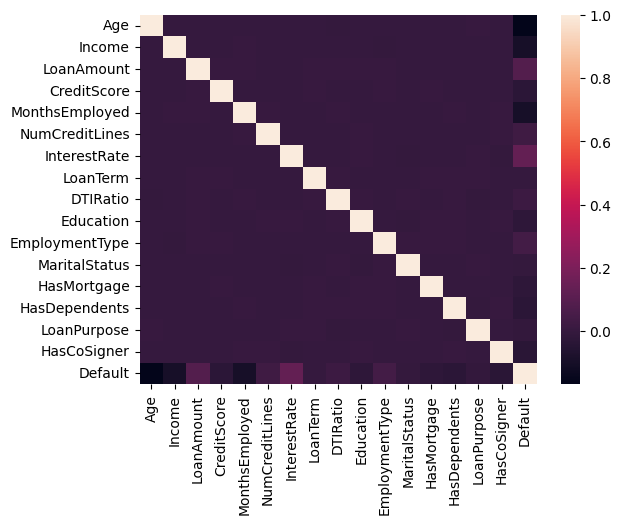

In [7]:
import seaborn as sns
cor = df.corr()
sns.heatmap(cor)

In [14]:
x,y = df.iloc[:,:16], df.iloc[:,16]

# coba training + balancing smote

In [ ]:
# normalisasi data 
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

x = std.fit_transform(x)

In [25]:
# over sampling penerapan 
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(x, y)

In [26]:
from sklearn.model_selection import train_test_split

#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [40]:
# basic lightgbm
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',  # Gunakan 'multiclass' jika ada lebih dari 2 kelas
    'boosting_type': 'gbdt',  # Algoritma boosting (bisa gbdt, dart, goss, etc.)
    'metric': 'binary_logloss',  # Metric evaluasi, sesuaikan dengan masalah (misal untuk multiclass: 'multi_logloss')
    'num_leaves': 31,  # Sesuaikan dengan dataset, default 31
    'learning_rate': 0.5,
    'feature_fraction': 0.9  # Subsample fitur
}

bst = lgb.train(params, train_data, valid_sets=[test_data])


[LightGBM] [Info] Number of positive: 180543, number of negative: 180567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 361110, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499967 -> initscore=-0.000133
[LightGBM] [Info] Start training from score -0.000133


In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

predictions = bst.predict(X_test)

y_pred_binary = np.where(predictions > 0.5, 1, 0)
#Calculating accuracy

accuracy = accuracy_score(y_test, y_pred_binary )

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.9307140167039589

Confusion Matrix:
 [[44448   679]
 [ 5576 39575]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93     45127
         1.0       0.98      0.88      0.93     45151

    accuracy                           0.93     90278
   macro avg       0.94      0.93      0.93     90278
weighted avg       0.94      0.93      0.93     90278



In [44]:
# training dengna hyperparameter
from sklearn.model_selection import GridSearchCV

params = {
    'objective': ['binary'],  # Gunakan 'multiclass' jika ada lebih dari 2 kelas
    'boosting_type': ['gbdt','dart','goss','rf'],  # Algoritma boosting (bisa gbdt, dart, goss, etc.)
    'metric': ['binary_logloss'],  # Metric evaluasi, sesuaikan dengan masalah (misal untuk multiclass: 'multi_logloss')
    'num_leaves': [10,30],  # Sesuaikan dengan dataset, default 31
    'learning_rate': [0.01,0.05,0.5],
    'feature_fraction': [0.5,0.9]  # Subsample fitur
}
lighbm = lgb.LGBMClassifier()

grid_search = GridSearchCV(
    estimator= lighbm,
    param_grid=params,
    scoring='accuracy',
    n_jobs = 1,
    cv = 10
)
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 162489, number of negative: 162510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 324999, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499968 -> initscore=-0.000129
[LightGBM] [Info] Start training from score -0.000129
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=

GridSearchCV(cv=10, estimator=LGBMClassifier(), n_jobs=1,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                         'feature_fraction': [0.5, 0.9],
                         'learning_rate': [0.01, 0.05, 0.5],
                         'metric': ['binary_logloss'], 'num_leaves': [10, 30],
                         'objective': ['binary']},
             scoring='accuracy')

In [45]:
print("Parameter terbaik:", grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Parameter terbaik: {'boosting_type': 'dart', 'feature_fraction': 0.5, 'learning_rate': 0.5, 'metric': 'binary_logloss', 'num_leaves': 30, 'objective': 'binary'}
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Akurasi: 0.9332727796362348

Confusion Matrix:
 [[44830   297]
 [ 5727 39424]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     45127
         1.0       0.99      0.87      0.93     45151

    accuracy                           0.93     90278
   macro avg       0.94      0.93      0.93     90278
weighted avg       0.94      0.93      0.93     90278



# coba information gain 

In [16]:
# menggunakan information gain 
from sklearn.feature_selection import mutual_info_classif

# Menghitung information gain
info_gain = mutual_info_classif(x,y, discrete_features='auto',n_neighbors=3, copy=True, random_state=None)

# Menyajikan hasil dalam bentuk dataframe
feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Information Gain': info_gain
}).sort_values(by='Information Gain', ascending=False)

# Menampilkan fitur dan nilai Information Gain
print(feature_importance)


           Feature  Information Gain
15     HasCoSigner          0.035968
13   HasDependents          0.035364
12     HasMortgage          0.033480
11   MaritalStatus          0.018825
0              Age          0.014930
10  EmploymentType          0.010932
9        Education          0.010399
5   NumCreditLines          0.010348
14     LoanPurpose          0.010024
7         LoanTerm          0.008547
6     InterestRate          0.008403
1           Income          0.007627
4   MonthsEmployed          0.005519
2       LoanAmount          0.004010
3      CreditScore          0.001036
8         DTIRatio          0.000831


In [18]:
# menggunakan chi square
from sklearn.feature_selection import SelectKBest, chi2

# Seleksi fitur terbaik berdasarkan uji chi-square
select_k_best = SelectKBest(chi2, k=5)  # Pilih 5 fitur terbaik
X_new = select_k_best.fit_transform(x, y)

# Mengambil boolean array yang menunjukkan fitur yang dipilih
selected_features_mask = select_k_best.get_support()

# Mengambil nama fitur yang dipilih
selected_features = x.columns[selected_features_mask]

# Mencetak fitur yang dipilih
print(f"Fitur yang dipilih: {selected_features.tolist()}")

Fitur yang dipilih: ['Age', 'Income', 'LoanAmount', 'MonthsEmployed', 'InterestRate']


In [22]:
from sklearn.decomposition import PCA

# Reduksi dimensi menggunakan PCA
pca = PCA(n_components=5)  # Memilih 5 komponen utama
X_pca = pca.fit_transform(x)

# Membuat DataFrame untuk menampilkan kontribusi fitur terhadap komponen
pca_components = pd.DataFrame(
    pca.components_, 
    columns=x.columns,  # Nama kolom sesuai dengan fitur asli
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # Nama komponen utama
)

# Tampilkan kontribusi (loading matrix)
print(pca_components)

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

              Age        Income    LoanAmount  CreditScore  MonthsEmployed  \
PC1  4.681284e-07  6.823556e-04 -9.999998e-01    -0.000003       -0.000001   
PC2  4.796979e-07 -9.999998e-01 -6.823556e-04     0.000006       -0.000002   
PC3 -5.208098e-05  5.829186e-06 -2.826702e-06     1.000000        0.000140   
PC4  1.765299e-04  2.381721e-06  1.377878e-06     0.000140       -1.000000   
PC5 -1.076702e-03 -4.319740e-07  6.078419e-07     0.000122       -0.000755   

     NumCreditLines  InterestRate      LoanTerm      DTIRatio     Education  \
PC1   -1.253812e-08  2.145537e-07 -6.080391e-07 -3.658457e-09 -4.028932e-08   
PC2    5.777957e-08  3.928194e-07  4.333677e-07 -1.226142e-09  2.760868e-08   
PC3    8.575728e-08  1.823066e-05  1.216011e-04 -1.511708e-06  1.476408e-06   
PC4   -4.100570e-05 -2.141044e-05  7.548588e-04 -1.173947e-05  4.226247e-05   
PC5    1.512668e-05 -4.128219e-04 -9.999990e-01 -3.089423e-05  1.992404e-04   

     EmploymentType  MaritalStatus   HasMortgage  HasDep